# Над проектом работали: 
* Бутаев Александр 
* Кильдияров Тимур
* Вероника Бурдельная
* Кирилл Шестаков

## Pull Data

In [9]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy import where
import yfinance as yf
from tqdm.autonotebook import tqdm

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from dtaidistance import dtw, clustering
import scipy.cluster.hierarchy as shc

import tsfel
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 500)

In [10]:
def get_info(crypto_obj):
    info_keys = ['shortName']
    info_values = []
    for key in info_keys:
        info_values.append(crypto_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [11]:
crypto_tickers = ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'TON-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'RUNE-USD', 'TWT-USD', 'ZEC-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'FTM-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'MIOTA-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'NEO-USD', 'GLM-USD', 'WAXP-USD', 'XEC-USD', 'QNT-USD', 'MANA-USD',
          'SAND-USD', 'FRAX-USD']

In [12]:
load = False
if load:
    crypto_data = []
    for ticker in tqdm(crypto_tickers):  
        try:
            crypto_obj = yf.Ticker(ticker)
            close_price = crypto_obj.history(interval='1d', start="2021-10-07", 
                                             end="2022-11-02"
                                            )['Close'].to_dict()
            info = get_info(crypto_obj)
            info.update(close_price)
            crypto_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    crypto_dff = pd.DataFrame(crypto_data)
    crypto_df = pd.DataFrame(crypto_dff.iloc[:,1:].pct_change(axis='columns'))
    crypto_df.insert(0, "shortName", crypto_dff.shortName)
    crypto_df.to_csv('data_task4.csv')

else: 
    crypto_df = pd.read_csv("data_task4.csv", index_col=0)
    #datetime_columns = pd.to_datetime(crypto_df.columns[5:])
    #crypto_df.columns = list(crypto_df.columns[:5]) + list(datetime_columns)

  0%|          | 0/50 [00:00<?, ?it/s]

* считаем наны и удаляем их

In [13]:
sh_name = crypto_df.iloc[:,:1]
all_dates= crypto_df.iloc[:,2:]
crypto_df = sh_name.join(all_dates)

* теперь у нас нет нанов

## Anomaly Detection

### Data Normalization 

In [14]:
sc = StandardScaler()
crypto_data_sc = sc.fit_transform(crypto_df.iloc[:,1:].T).T

In [15]:
crypto_data_sc = pd.DataFrame(crypto_data_sc, index=crypto_df['shortName'], columns = crypto_df.iloc[:,1:].columns)
crypto_data_sc.shape

(50, 390)

In [16]:
from sklearn.ensemble import IsolationForest

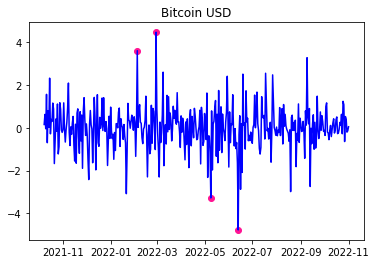

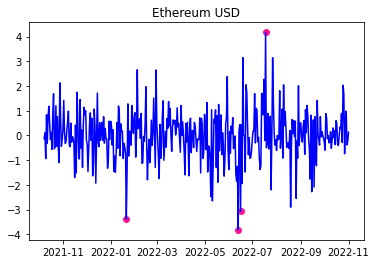

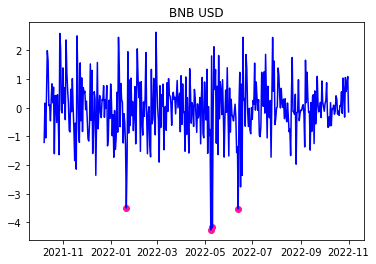

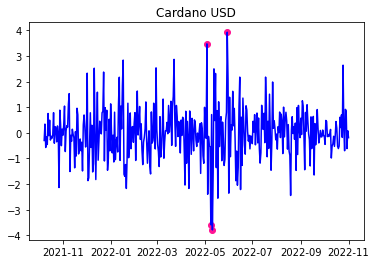

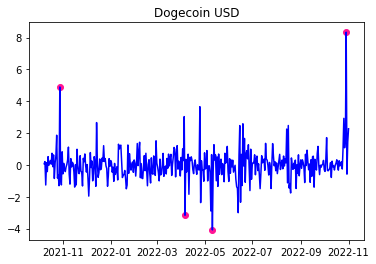

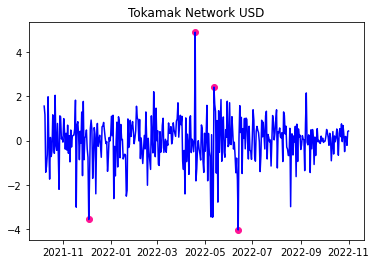

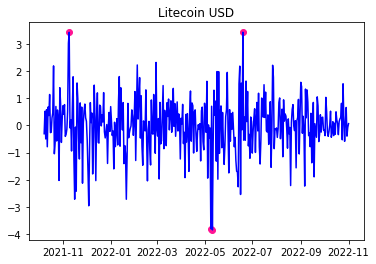

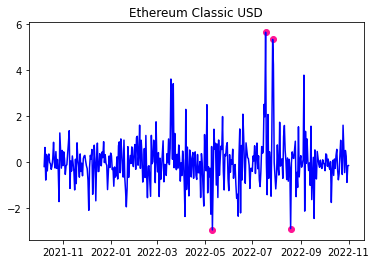

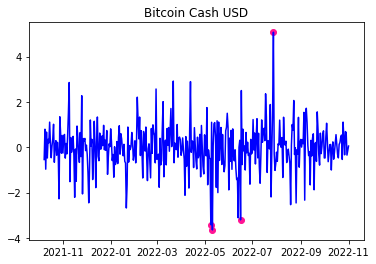

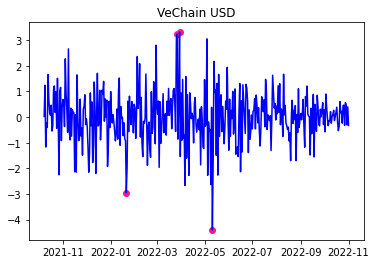

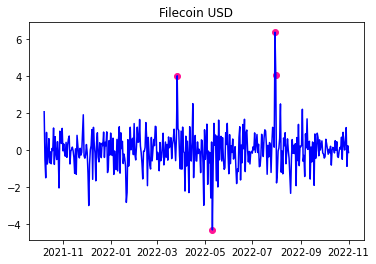

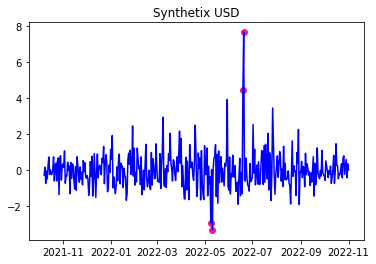

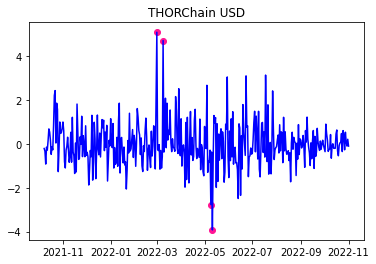

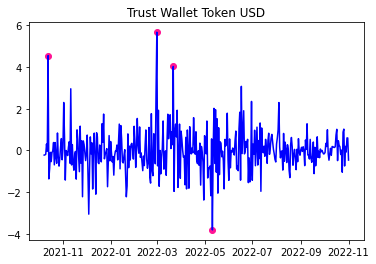

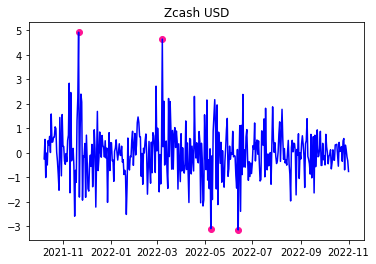

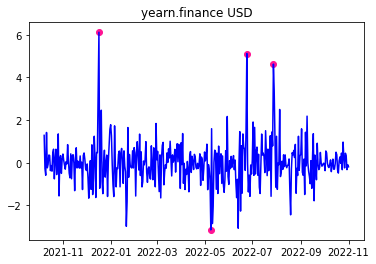

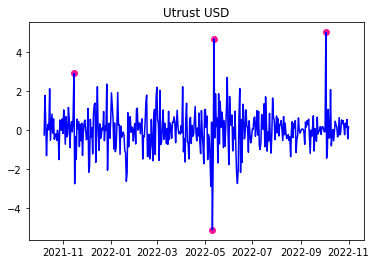

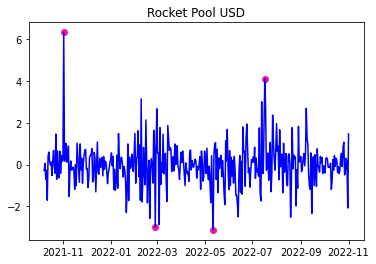

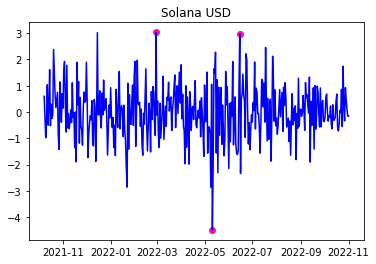

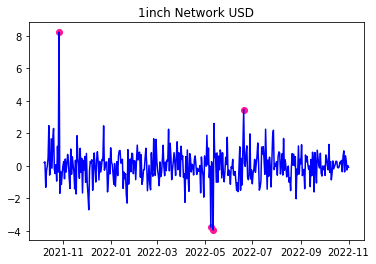

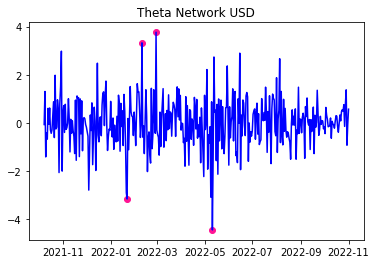

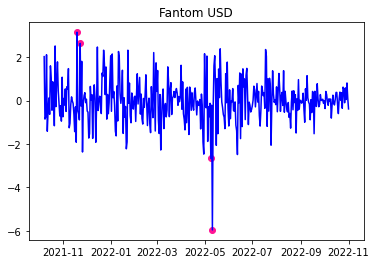

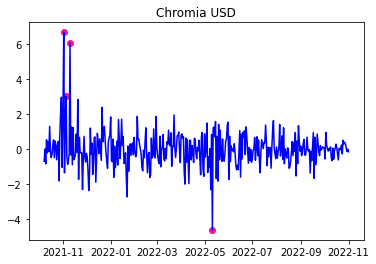

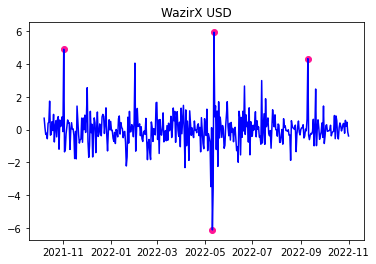

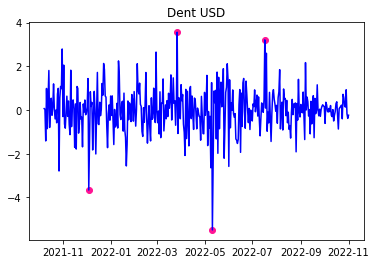

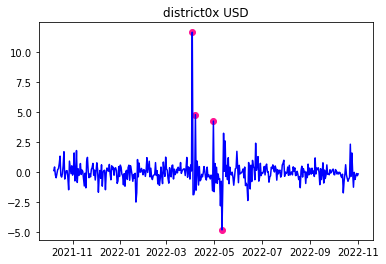

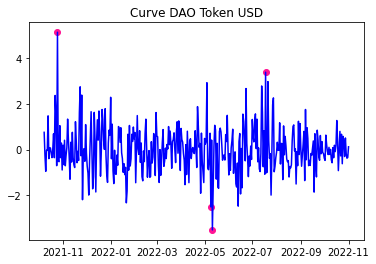

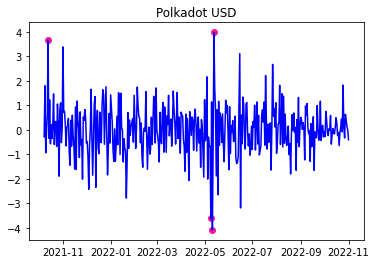

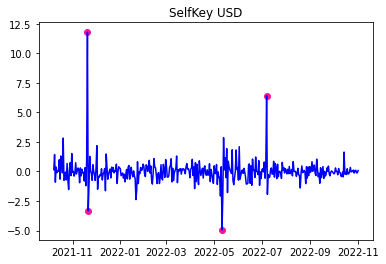

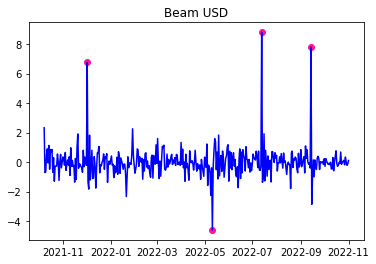

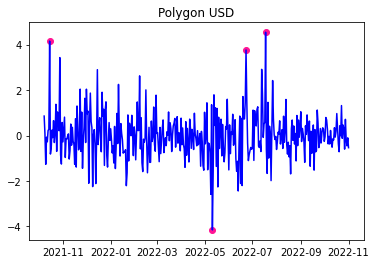

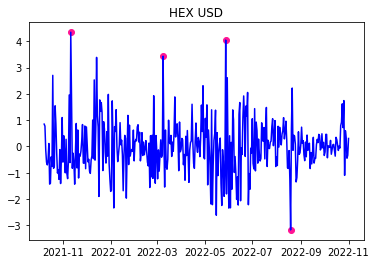

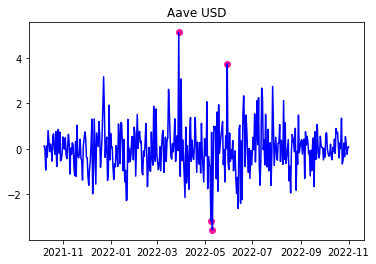

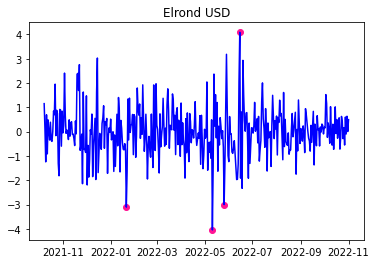

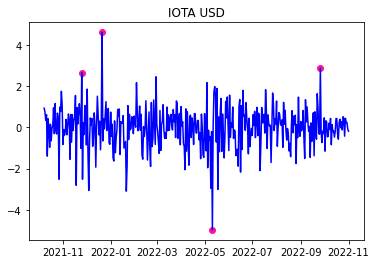

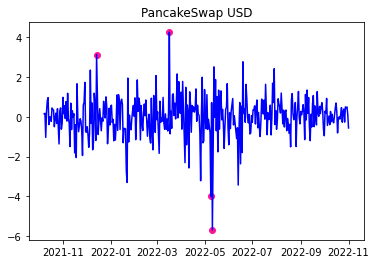

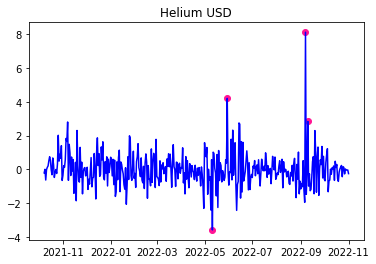

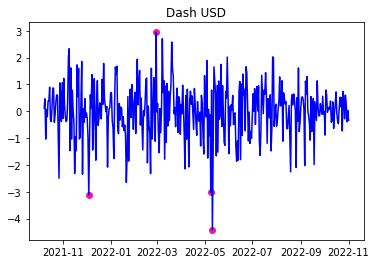

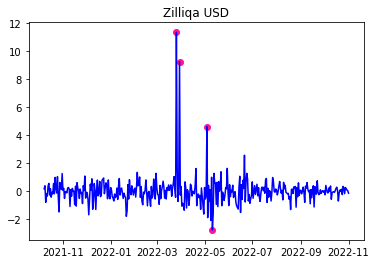

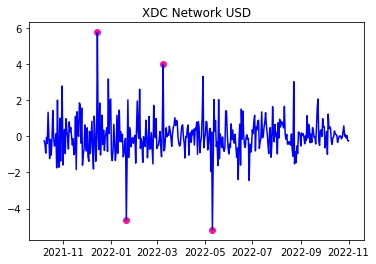

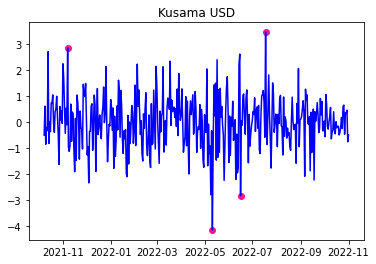

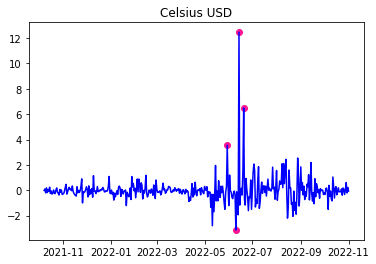

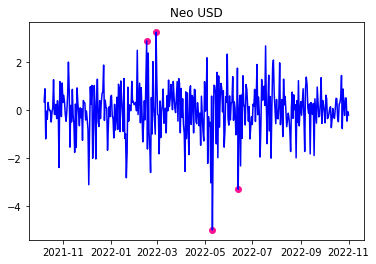

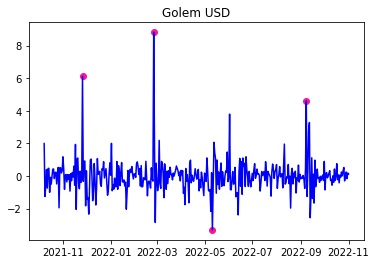

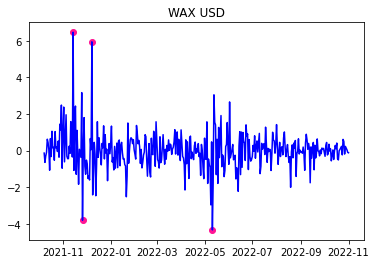

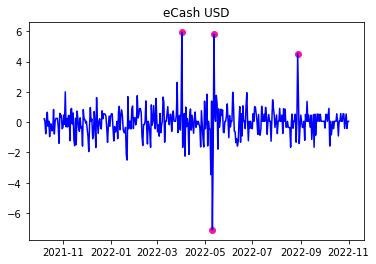

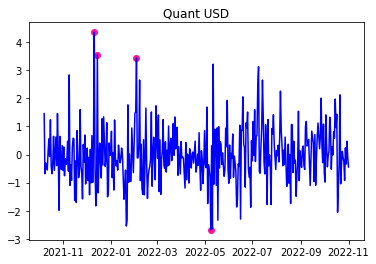

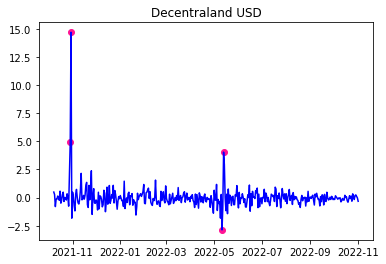

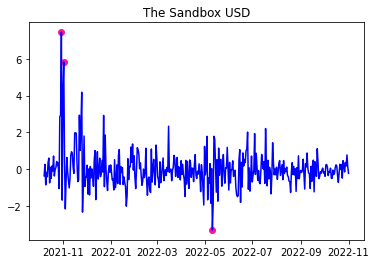

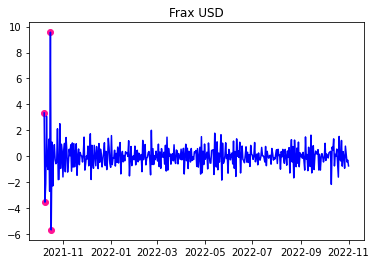

In [17]:
outliers_fraction = 0.01
iso = IsolationForest(n_estimators=100,max_samples='auto',max_features=1.0,contamination=outliers_fraction)

anomalies = []

for i in range(50):
    model = iso.fit(pd.DataFrame(crypto_data_sc.iloc[i,:].T))
    y_pred = model.predict(pd.DataFrame(crypto_data_sc.iloc[i,:].T))
        
    outlier_index = where(y_pred == -1) 
    outlier_values = pd.DataFrame(crypto_data_sc.iloc[i,:].T).iloc[outlier_index]
    
    fig, ax = plt.subplots()
    plt.plot(crypto_data_sc.iloc[i,:], color = 'blue')
    plt.scatter(outlier_values.index, outlier_values.values, c = "deeppink")
    anomalies.append(outlier_values)
    plt.title(crypto_data_sc.index[i])

In [18]:
crypto_data_sc = crypto_data_sc.T 
clean_data = pd.DataFrame()


for m in range(len(anomalies)):

    df = crypto_data_sc.join(anomalies[m], lsuffix='', rsuffix='_other')

    x = anomalies[m].columns[0]

    df['shf1'], df['shf2'] = df[x].shift(1), df[x].shift(-1)

    h = list(df.index[df[x+'_other'].isna() == False])

    for i in range(len(h)):
        df.at[h[i], x] =  (df.loc[df[x+'_other'].isna() == False]['shf1'][i] + df.loc[df[x+'_other'].isna() == False]['shf2'][i]) / 2

    df = df.drop([x+'_other', 'shf1', 'shf2'], axis=1)

    clean_data = df

clean_data = clean_data.fillna(method="ffill").fillna(method="bfill")
clean_data = clean_data.T
clean_data.head()

,2021-10-08 00:00:00+00:00,2021-10-09 00:00:00+00:00,2021-10-10 00:00:00+00:00,2021-10-11 00:00:00+00:00,2021-10-12 00:00:00+00:00,2021-10-13 00:00:00+00:00,2021-10-14 00:00:00+00:00,2021-10-15 00:00:00+00:00,2021-10-16 00:00:00+00:00,2021-10-17 00:00:00+00:00,...,2022-10-23 00:00:00+00:00,2022-10-24 00:00:00+00:00,2022-10-25 00:00:00+00:00,2022-10-26 00:00:00+00:00,2022-10-27 00:00:00+00:00,2022-10-28 00:00:00+00:00,2022-10-29 00:00:00+00:00,2022-10-30 00:00:00+00:00,2022-10-31 00:00:00+00:00,2022-11-01 00:00:00+00:00
Bitcoin USD,0.149166,0.618967,-0.050083,1.556872,-0.701695,0.792390,0.016210,2.313165,-0.286555,0.386791,...,0.623323,-0.284234,1.231527,1.073749,-0.647736,0.519768,0.385923,-0.207611,-0.146859,0.042652
Ethereum USD,-0.129250,0.104458,-0.942535,0.833654,-0.317481,0.779349,1.180128,0.494939,-0.166276,0.127829,...,0.891767,-0.286105,2.033121,1.686806,-0.743725,0.654627,0.981787,-0.386057,-0.235861,0.129653
BNB USD,-1.209490,0.160061,-1.055004,0.562033,1.991132,1.639857,0.075258,0.098407,-0.457963,0.291532,...,0.554880,-0.196809,1.034053,0.567293,-0.326846,1.055167,0.565066,0.849855,1.088600,-0.145441
Cardano USD,-0.296633,0.343671,-0.570988,-0.157813,-0.452288,0.757521,-0.109649,0.495081,-0.279741,-0.130339,...,0.704317,-0.176028,2.645292,0.146907,-0.697362,0.918555,0.857499,-0.614683,0.083609,-0.184963
Dogecoin USD,0.070315,0.208183,-1.262845,0.136475,-0.421811,0.518192,-0.024341,0.119934,0.277838,0.046838,...,0.202293,-0.258867,1.051278,2.923531,1.073631,1.655333,8.331489,-0.579986,1.451110,2.268807


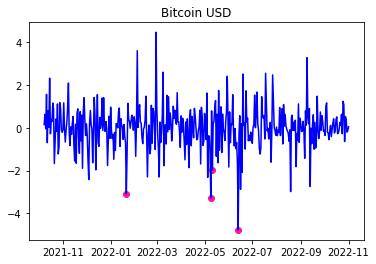

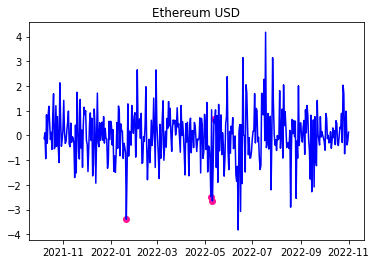

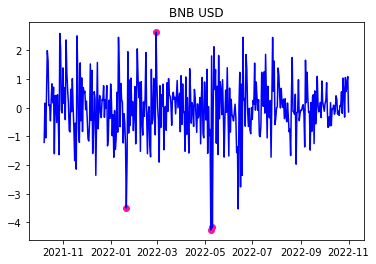

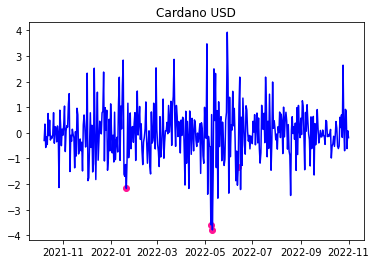

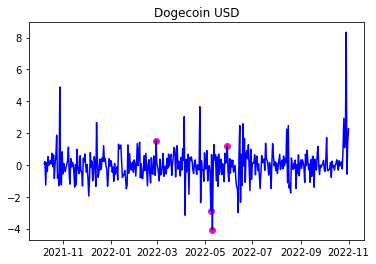

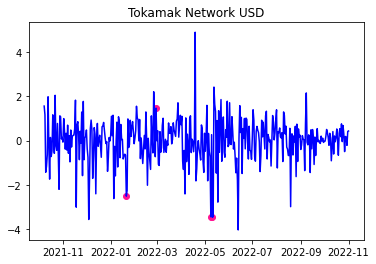

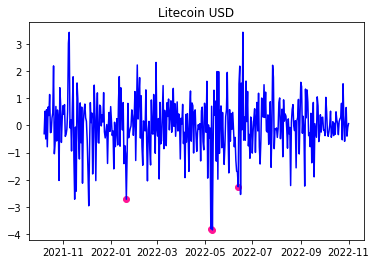

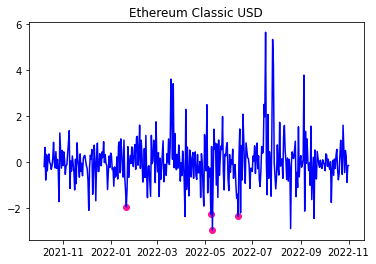

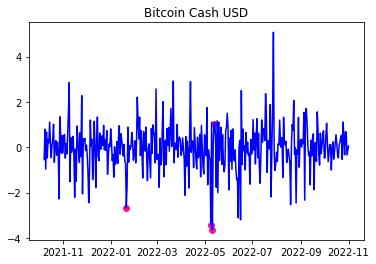

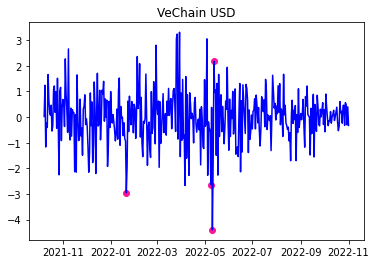

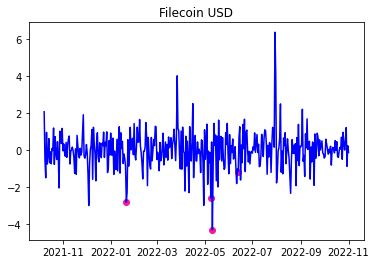

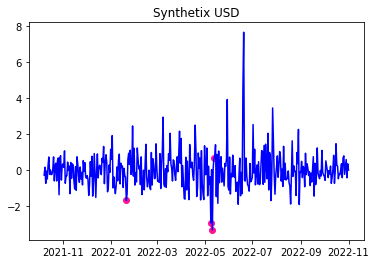

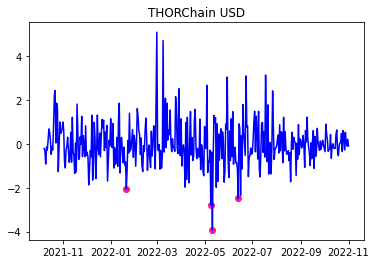

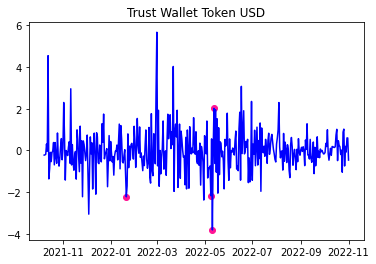

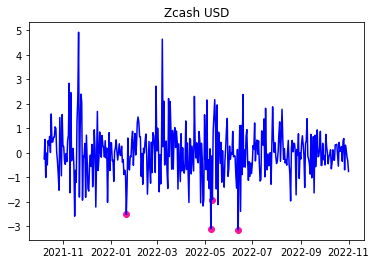

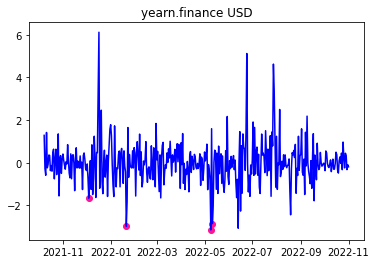

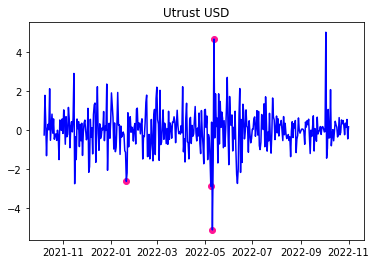

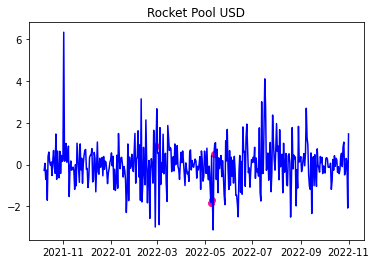

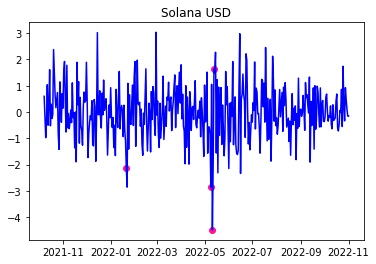

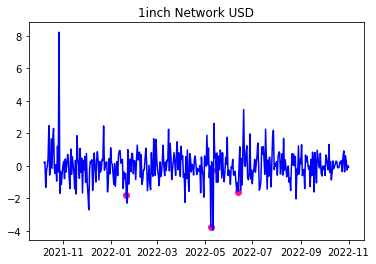

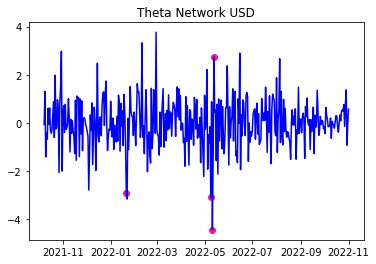

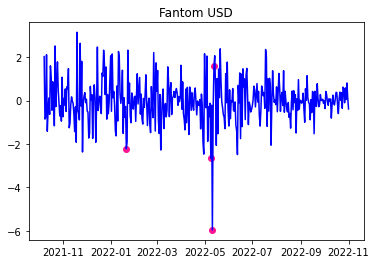

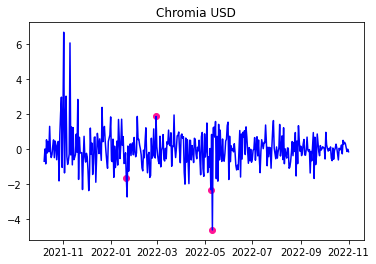

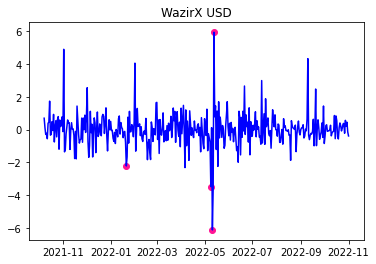

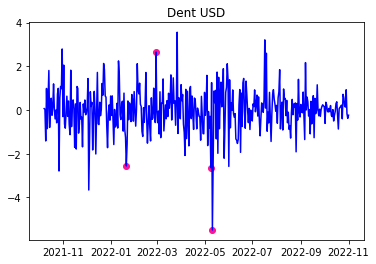

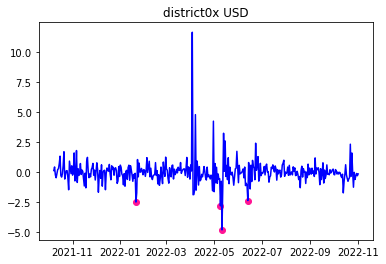

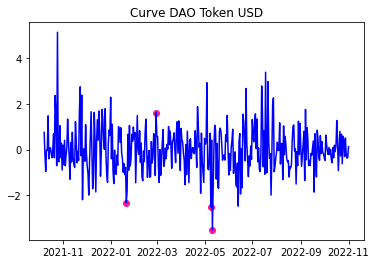

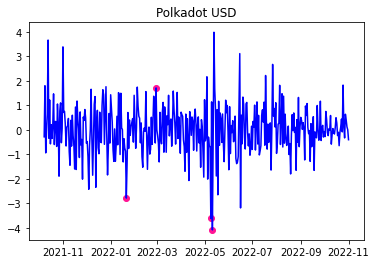

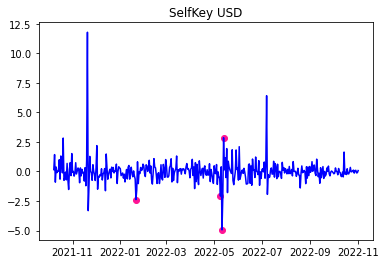

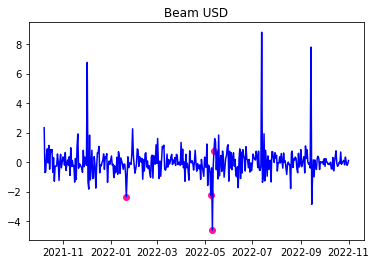

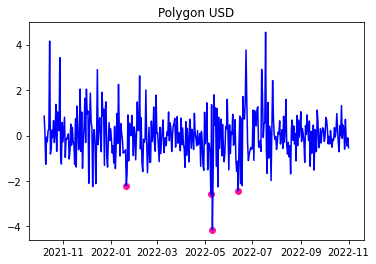

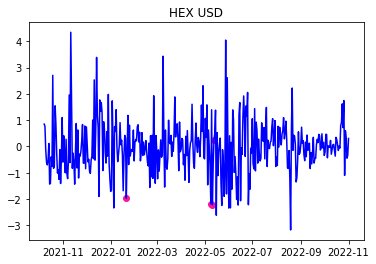

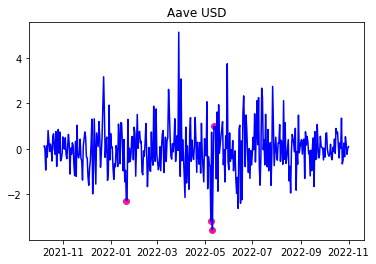

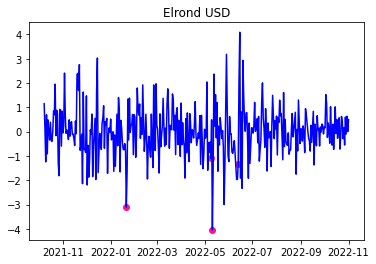

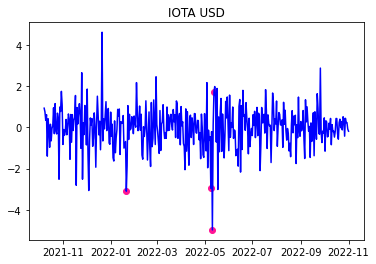

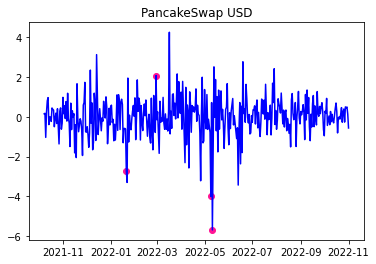

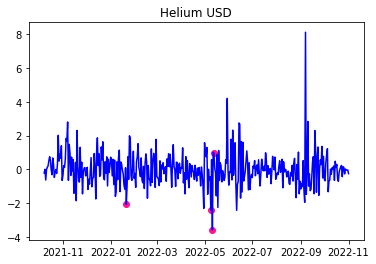

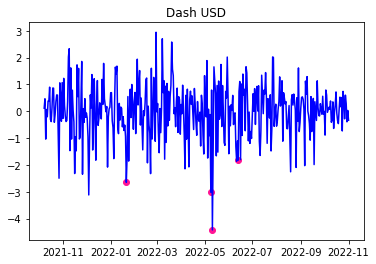

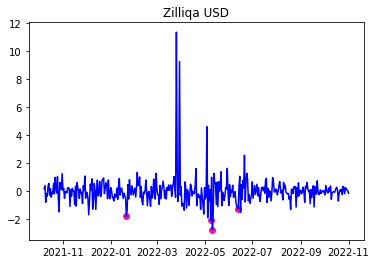

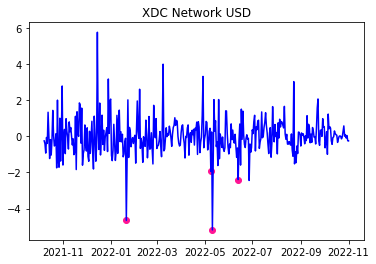

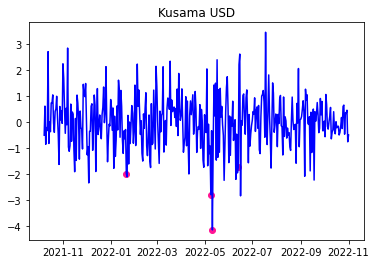

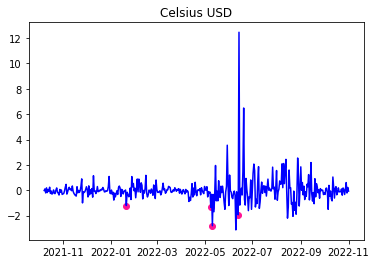

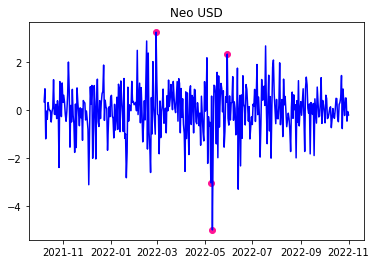

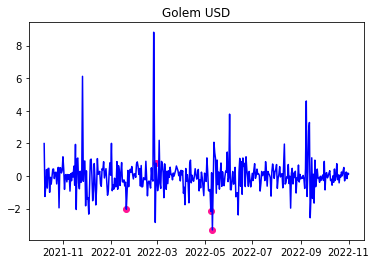

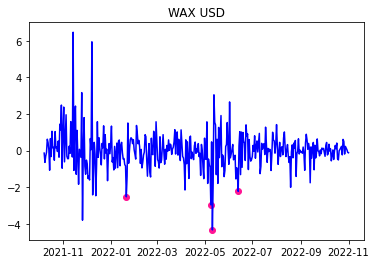

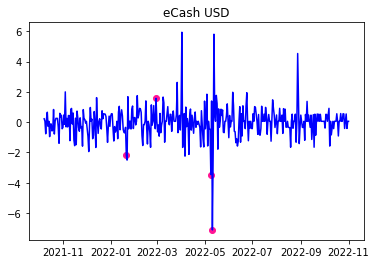

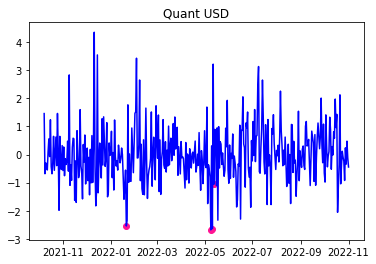

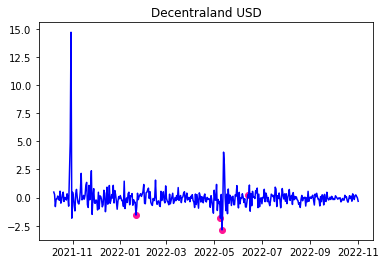

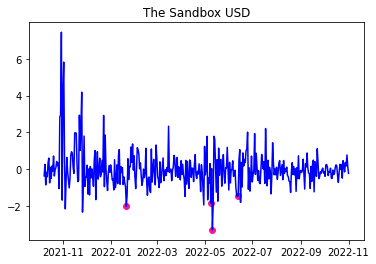

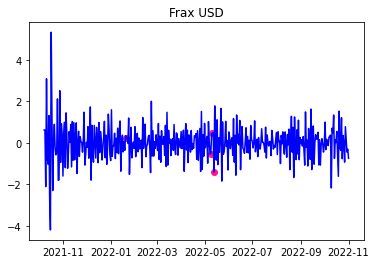

In [19]:
outliers_fraction = 0.01
iso = IsolationForest(n_estimators=100,max_samples='auto',max_features=1.0,contamination=outliers_fraction)

anomalies = []

for i in range(50):
    model = iso.fit(pd.DataFrame(clean_data.T))
    y_pred = model.predict(pd.DataFrame(clean_data.T))
        
    outlier_index = where(y_pred == -1) 
    outlier_values = pd.DataFrame(clean_data.iloc[i,:].T).iloc[outlier_index]
    
    fig, ax = plt.subplots()
    plt.plot(clean_data.iloc[i,:], color = 'blue')
    plt.scatter(outlier_values.index, outlier_values.values, c = "deeppink")
    anomalies.append(outlier_values)
    plt.title(clean_data.index[i])

In [20]:
clean_data.head(20)

,2021-10-08 00:00:00+00:00,2021-10-09 00:00:00+00:00,2021-10-10 00:00:00+00:00,2021-10-11 00:00:00+00:00,2021-10-12 00:00:00+00:00,2021-10-13 00:00:00+00:00,2021-10-14 00:00:00+00:00,2021-10-15 00:00:00+00:00,2021-10-16 00:00:00+00:00,2021-10-17 00:00:00+00:00,...,2022-10-23 00:00:00+00:00,2022-10-24 00:00:00+00:00,2022-10-25 00:00:00+00:00,2022-10-26 00:00:00+00:00,2022-10-27 00:00:00+00:00,2022-10-28 00:00:00+00:00,2022-10-29 00:00:00+00:00,2022-10-30 00:00:00+00:00,2022-10-31 00:00:00+00:00,2022-11-01 00:00:00+00:00
Bitcoin USD,0.149166,0.618967,-0.050083,1.556872,-0.701695,0.792390,0.016210,2.313165,-0.286555,0.386791,...,0.623323,-0.284234,1.231527,1.073749,-0.647736,0.519768,0.385923,-0.207611,-0.146859,0.042652
Ethereum USD,-0.129250,0.104458,-0.942535,0.833654,-0.317481,0.779349,1.180128,0.494939,-0.166276,0.127829,...,0.891767,-0.286105,2.033121,1.686806,-0.743725,0.654627,0.981787,-0.386057,-0.235861,0.129653
BNB USD,-1.209490,0.160061,-1.055004,0.562033,1.991132,1.639857,0.075258,0.098407,-0.457963,0.291532,...,0.554880,-0.196809,1.034053,0.567293,-0.326846,1.055167,0.565066,0.849855,1.088600,-0.145441
Cardano USD,-0.296633,0.343671,-0.570988,-0.157813,-0.452288,0.757521,-0.109649,0.495081,-0.279741,-0.130339,...,0.704317,-0.176028,2.645292,0.146907,-0.697362,0.918555,0.857499,-0.614683,0.083609,-0.184963
Dogecoin USD,0.070315,0.208183,-1.262845,0.136475,-0.421811,0.518192,-0.024341,0.119934,0.277838,0.046838,...,0.202293,-0.258867,1.051278,2.923531,1.073631,1.655333,8.331489,-0.579986,1.451110,2.268807
Tokamak Network USD,1.560850,1.170733,-1.428901,-1.157509,-0.632567,1.981436,-0.245616,-1.739254,0.142735,-0.718726,...,0.757225,-0.043791,0.680200,0.290076,-0.495580,0.188040,0.155167,-0.213349,0.415681,0.435129
Litecoin USD,-0.307863,0.518217,-0.499645,0.574196,-0.788138,0.676339,0.361841,1.134951,-0.268211,-0.252507,...,0.811051,-0.532196,1.529008,0.193129,-0.588399,0.126317,0.657730,-0.396522,-0.078811,0.063013
Ethereum Classic USD,-0.197502,0.632078,-0.788079,0.328687,-0.390413,0.209026,0.349246,-0.027958,-0.066239,-0.320043,...,0.136335,-0.544828,1.601987,0.537769,-0.462463,0.499939,0.255117,-0.889043,-0.171636,-0.154893
Bitcoin Cash USD,-0.538567,0.797860,-0.964583,0.670365,-0.471932,0.352398,0.196449,1.109954,0.143161,-0.460281,...,0.538362,-0.535929,1.111780,0.441685,-0.331550,0.693303,0.648881,-0.344198,-0.156778,0.055388
VeChain USD,0.024672,1.240509,-1.168670,-0.238920,-0.397894,1.658001,0.660159,0.179560,0.072185,0.461577,...,0.223818,-0.238555,0.449050,0.463945,-0.325747,0.561537,0.470216,-0.308311,0.398330,-0.327004


In [30]:
T_clean_data = clean_data.T
T_clean_data.head(20)

,Bitcoin USD,Ethereum USD,BNB USD,Cardano USD,Dogecoin USD,Tokamak Network USD,Litecoin USD,Ethereum Classic USD,Bitcoin Cash USD,VeChain USD,...,Kusama USD,Celsius USD,Neo USD,Golem USD,WAX USD,eCash USD,Quant USD,Decentraland USD,The Sandbox USD,Frax USD
2021-10-08 00:00:00+00:00,0.149166,-0.129250,-1.209490,-0.296633,0.070315,1.560850,-0.307863,-0.197502,-0.538567,0.024672,...,-0.506885,-0.021389,0.344040,1.993019,-0.137330,0.221736,1.456446,0.491977,-0.351822,0.615077
2021-10-09 00:00:00+00:00,0.618967,0.104458,0.160061,0.343671,0.208183,1.170733,0.518217,0.632078,0.797860,1.240509,...,0.614409,0.106598,0.886396,-1.252730,-0.646038,0.055125,-0.683846,0.269771,0.268592,0.615077
2021-10-10 00:00:00+00:00,-0.050083,-0.942535,-1.055004,-0.570988,-1.262845,-1.428901,-0.499645,-0.788079,-0.964583,-1.168670,...,-0.858334,-0.211565,-1.199623,-0.634677,-0.304088,-0.770456,-0.297702,-0.798501,-0.842135,-2.111100
2021-10-11 00:00:00+00:00,1.556872,0.833654,0.562033,-0.157813,0.136475,-1.157509,0.574196,0.328687,0.670365,-0.238920,...,-0.213049,0.187844,-0.045191,0.397078,-0.097236,0.227992,-0.363143,-0.142760,-0.160400,3.083639
2021-10-12 00:00:00+00:00,-0.701695,-0.317481,1.991132,-0.452288,-0.421811,-0.632567,-0.788138,-0.390413,-0.471932,-0.397894,...,-0.327643,-0.180773,-0.388013,-0.738196,0.620312,0.654537,-0.550220,-0.145300,-0.399218,-0.721673
2021-10-13 00:00:00+00:00,0.792390,0.779349,1.639857,0.757521,0.518192,1.981436,0.676339,0.209026,0.352398,1.658001,...,2.715261,0.061800,0.313206,0.464139,0.436518,-0.276595,0.096339,0.136328,0.374531,-1.027810
2021-10-14 00:00:00+00:00,0.016210,1.180128,0.075258,-0.109649,-0.024341,-0.245616,0.361841,0.349246,0.196449,0.660159,...,-0.825717,-0.070102,0.064289,0.473408,0.038502,0.055125,0.555035,0.039549,0.612170,1.315460
2021-10-15 00:00:00+00:00,2.313165,0.494939,0.098407,0.495081,0.119934,-1.739254,1.134951,-0.027958,1.109954,0.179560,...,0.002605,0.240925,-0.023630,-0.997990,-1.072140,-0.958296,-0.073743,-0.234885,-0.734313,-2.702546
2021-10-16 00:00:00+00:00,-0.286555,-0.166276,-0.457963,-0.279741,0.277838,0.142735,-0.268211,-0.066239,0.143161,0.072185,...,-0.372199,-0.248418,-0.019378,-0.078074,0.654784,-0.123617,1.235695,0.572469,0.111087,-4.195177
2021-10-17 00:00:00+00:00,0.386791,0.127829,0.291532,-0.130339,0.046838,-0.718726,-0.252507,-0.320043,-0.460281,0.461577,...,0.736980,-0.059172,-0.498876,-0.499515,-0.327403,-0.125370,-0.432668,-0.493881,-0.488453,5.327305


# Кластеризация данных на основании DTW distance

  0%|          | 0/8 [00:00<?, ?it/s]

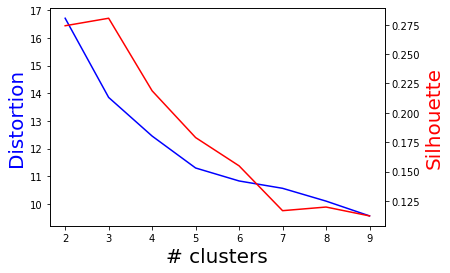

In [22]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(T_clean_data)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(T_clean_data, kmeanModel.labels_, metric="dtw"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters',  fontsize = 20)
ax1.set_ylabel('Distortion', color='b',  fontsize = 20)
ax2.set_ylabel('Silhouette', color='r',  fontsize = 20)

plt.show()

Возьму 4  
Красная штучка высокая и тангенс сильнее меняется с четвертого по пятый

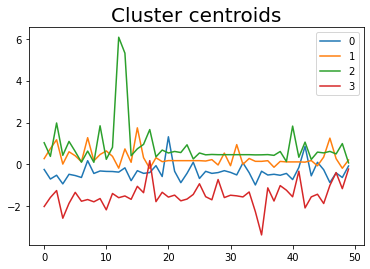

In [23]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(T_clean_data)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids",  fontsize = 20)
plt.legend()
plt.show()

Получилось неплохо

In [ ]:
# иерархический dtw
T_clean_data = T_clean_data.to_numpy()
# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(T_clean_data)
# Keep track of full tree by using the HierarchicalTree wrapper class
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(T_clean_data)
# You can also pass keyword arguments identical to instantiate a Hierarchical object
model2 = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model2.fit(T_clean_data)
# SciPy linkage clustering
dtw_cluster = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = dtw_cluster.fit(T_clean_data)

100%|██████████████████████████████████████████████████████████████████████████████▊| 389/390 [00:00<00:00, 886.23it/s]


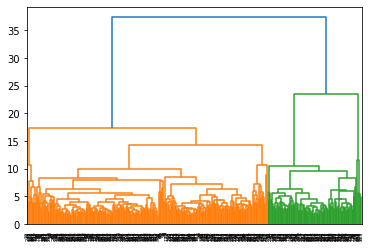

In [ ]:
shc.dendrogram(cluster_idx)
plt.show()

# Кластеризация данных наиболее подходящим методом*

*по нашему мнению

Интересный и эффективный способ кластеризации временных рядов заключается в выделении некоторых признаков во временных рядах, а затем последующая кластеризация по получившемуся признаковому пространству. Лучший результат был получен при использовании статистических характеристик временных рядов.

In [103]:
data_tsfel = T_clean_data.T.to_numpy()

In [104]:
import tsfel
fs = 100
cfg_file = tsfel.get_features_by_domain('statistical')

EXTRACT = True

if EXTRACT:
    X_train = tsfel.time_series_features_extractor(cfg_file, data_tsfel, fs=fs)
    X_train.to_csv('X_train_tsfel.csv')

*** Feature extraction started ***



*** Feature extraction finished ***


In [105]:
X_train.shape

(50, 36)

In [106]:
X_train.head(3)

,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,0_ECDF_4,0_ECDF_5,...,0_Max,0_Mean,0_Mean absolute deviation,0_Median,0_Median absolute deviation,0_Min,0_Root mean square,0_Skewness,0_Standard deviation,0_Variance
0,78.0,312.0,-0.647736,0.636937,0.002564,0.005128,0.007692,0.010256,0.012821,0.015385,...,4.457539,-9.109522e-18,0.706910,0.002481,0.510463,-4.774950,1.0,-0.164681,1.0,1.0
1,78.0,312.0,-0.680423,0.714303,0.002564,0.005128,0.007692,0.010256,0.012821,0.015385,...,4.175063,4.554761e-18,0.743732,-0.020179,0.541101,-3.824267,1.0,-0.030183,1.0,1.0
2,78.0,312.0,-0.736595,0.766336,0.002564,0.005128,0.007692,0.010256,0.012821,0.015385,...,2.633384,-5.693451e-18,0.738026,0.004022,0.547388,-4.262501,1.0,-0.420836,1.0,1.0


In [107]:
from sklearn.feature_selection import VarianceThreshold
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)

In [108]:
X_train.shape

(50, 17)

In [109]:
kmeanModel_tsfel = KMeans(n_clusters=4)
kmeanModel_tsfel.fit(X_train)

KMeans(n_clusters=4)

In [110]:
clusters_tsfel = kmeanModel_tsfel.predict(X_train)

Выделю две главные компоненты для того, чтобы визуализировать полученный результат:

In [111]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = X_pca , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame(clusters_tsfel, columns=['Cluster'])], axis = 1)
finalDf.head(3)

,principal component 1,principal component 2,Cluster
0,-5.009954,-4.461507,1
1,-14.275744,-4.416871,1
2,-8.681799,-5.341389,1


In [112]:
def plot_pca(finalDf):
  fig = plt.figure(figsize = (8,6))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)
  targets = [0, 1, 2, 3]
  colors = ['r', 'g', 'b', 'k']
  for target, color in zip(targets,colors):
      indicesToKeep = finalDf['Cluster'] == target
      ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                , finalDf.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()

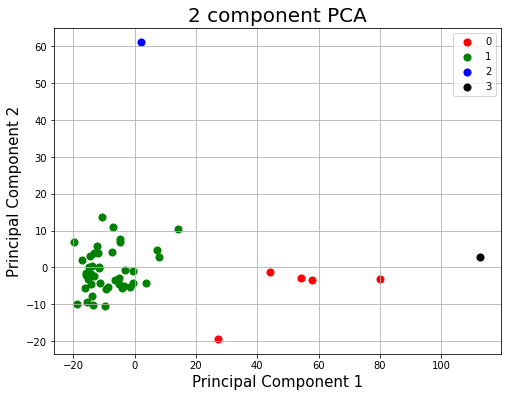

In [113]:
plot_pca(finalDf)

Кластеры хорошо отделились друг от друга.

In [114]:
silhouette_score(X_train, kmeanModel_tsfel.labels_)

0.5795672630126867

Коэффициент силуэта достаточно высок, поэтому можно говорить об удачности полученной кластеризации объектов.

In [115]:
finalDf['Cluster'].value_counts()

1    43
0     5
2     1
3     1
Name: Cluster, dtype: int64

In [116]:
finalDf.insert(2, "coin", ['BTC-USD','ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'TON-USD', 'LTC-USD', 'ETC-USD', 
           'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD', 'RUNE-USD', 'TWT-USD', 'ZEC-USD', 'YFI-USD',
          'UTK-USD', 'RPL-USD', 'SOL-USD', '1INCH-USD', 'THETA-USD', 'FTM-USD', 'CHR-USD', 'WRX-USD',
          'DENT-USD', 'DNT-USD', 'CRV-USD', 'DOT-USD', 'KEY-USD', 'BEAM-USD', 'MATIC-USD', 'HEX-USD',
           'AAVE-USD', 'EGLD-USD', 'MIOTA-USD', 'CAKE-USD', 'HNT-USD', 'DASH-USD', 'ZIL-USD','XDC-USD',
           'KSM-USD','CEL-USD', 'NEO-USD', 'GLM-USD', 'WAXP-USD', 'XEC-USD', 'QNT-USD', 'MANA-USD',
          'SAND-USD', 'FRAX-USD'], False)

In [117]:
finalDf[finalDf['Cluster'] == 0].coin.values

array(['DNT-USD', 'KEY-USD', 'BEAM-USD', 'ZIL-USD', 'CEL-USD'],
      dtype=object)

In [118]:
finalDf[finalDf['Cluster'] == 1].coin.values

array(['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'DOGE-USD', 'TON-USD',
       'LTC-USD', 'ETC-USD', 'BCH-USD', 'VET-USD', 'FIL-USD', 'SNX-USD',
       'RUNE-USD', 'TWT-USD', 'ZEC-USD', 'YFI-USD', 'UTK-USD', 'RPL-USD',
       'SOL-USD', '1INCH-USD', 'THETA-USD', 'FTM-USD', 'CHR-USD',
       'WRX-USD', 'DENT-USD', 'CRV-USD', 'DOT-USD', 'MATIC-USD',
       'HEX-USD', 'AAVE-USD', 'EGLD-USD', 'MIOTA-USD', 'CAKE-USD',
       'HNT-USD', 'DASH-USD', 'XDC-USD', 'KSM-USD', 'NEO-USD', 'GLM-USD',
       'WAXP-USD', 'QNT-USD', 'SAND-USD', 'FRAX-USD'], dtype=object)

In [119]:
finalDf[finalDf['Cluster'] == 2].coin.values

array(['XEC-USD'], dtype=object)

In [120]:
finalDf[finalDf['Cluster'] == 3].coin.values

array(['MANA-USD'], dtype=object)

Были найдены коины, которые не попали в один кластер с биткоином. Эфир и биткоин попали в один кластер, что говорит об адекватности кластеризации. В рамках выполненной командной работы:
*   были собраны данные по криптовалютам с использованием yfinance
*   данные были нормированы для корректной работы distance-based алгоритмов
*   были удалены аномалии с помощью применения IsolationForest
*   криптовалюты были кластеризованы на основании dtw distance при использовании tslearn
*   коины были также кластеризованы с использованием feature extraction


> Найденные кластеры помогут инвестору диверсифицировать свой портфель, поскольку были найдены коины, движение которых отличается от движения маркет-мейкера - биткоина.







